# Haplotype age tree

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import hapclust

In [2]:
# load data
callset_haps = np.load('../../data/phase2/haps.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])

In [3]:
tbl_variants_selected = etl.frompickle('../../data/phase2/tbl_variants_missense_selected.pkl')
tbl_variants_selected

0|CHROM,1|POS,2|num_alleles,3|REF,4|ALT,5|AC,6|ALTIX,7|FILTER_PASS,8|NoCoverage,9|LowCoverage,10|HighCoverage,11|LowMQ,12|HighMQ0,13|RepeatDUST,14|RepeatMasker,15|RepeatTRF,16|FS,17|HRun,18|QD,19|ReadPosRankSum,20|SNPEFF_Allele,21|SNPEFF_Annotation,22|SNPEFF_HGVS_c,23|SNPEFF_HGVS_p,24|SNPEFF_Feature_ID,25|SNPEFF_CDS_pos,26|AF_AOcol,27|AF_BFcol,28|AF_GHcol,29|AF_CIcol,30|AF_GNcol,31|AF_GW,32|AF_GM,33|AF_GNgam,34|AF_BFgam,35|AF_GHgam,36|AF_CMgam,37|AF_UGgam,38|AF_GAgam,39|AF_GQgam,40|AF_FRgam,41|AF_KE,42|check_allele,43|exon_start,44|exon_end,45|exon,46|AGAP004707-RA,47|AGAP004707-RB,48|AGAP004707-RC,49|Davies-C1N2,50|Davies-C3N2,51|Davies-C5N2,52|Davies-C7N2,53|Davies-C8N2,54|Davies-C10N2,55|Davies-C11N2,56|Davies-C1N9,57|Davies-C8N9,58|Davies-C1N9ck
2L,2390177,2,G,A,215,0,True,0,4,13,0,0,False,False,False,0.479,1,19.5,1.877,A,missense_variant,n.761G>A,p.Arg254Lys,AGAP004707-RA,761,0.0,0.0,0.00909090909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313131313131,0.0,0.202898550725,0.0,0.0,0.0,True,2390129,2390341,7,R254K,R254K,R254K,R260K,R217K,R260K,R260K,R271K,R260K,R260K,R260K,R271K,R260K
2L,2391228,3,G,C,38,0,True,0,0,15,0,0,False,False,False,1.1973,0,15.109,-1.2637,C,missense_variant,n.1204G>C,p.Val402Leu,AGAP004707-RA,1204,0.0,0.0733333333333,0.127272727273,0.0845070422535,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2391228,3,G,T,14,1,True,0,0,15,0,0,False,False,False,1.1973,0,15.109,-1.2637,None,None,None,None,None,None,0.0,0.06,0.0454545454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2399997,2,G,C,41,0,True,0,2,11,0,0,False,False,False,13.234,0,15.469,0.065979,C,missense_variant,n.1396G>C,p.Asp466His,AGAP004707-RA,1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0690235690236,0.0,0.0,0.0,0.0,0.0,True,2399898,2400173,11i+,D466H,D466H,D466H,D472H,D429H,D417H,D472H,D483H,D472H,D472H,D472H,D483H,D472H
2L,2400071,3,G,A,22,0,True,0,1,14,0,0,False,False,False,2.1289,0,26.594,0.39111,A,missense_variant,n.1470G>A,p.Met490Ile,AGAP004707-RA,1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0307692307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,True,2399898,2400173,11i+,M490I,M490I,M490I,M496I,M453I,M441I,M496I,M507I,M496I,M496I,M496I,M507I,M496I


In [4]:
tbl_selected_redux = (
    tbl_variants_selected
    # TODO add multi-allelics and fails back in
    .eq('num_alleles', 2)
    .true('FILTER_PASS')
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .mergeduplicates(key=('POS'))
    .convert('ALT', lambda v: ','.join(v) if len(v) > 1 else v)
    .addfield('label',  lambda rec: '%s:%s>%s %s' % (rec.POS, rec.REF, rec.ALT.ljust(3), rec['AGAP004707-RA'].rjust(6)))
    .sort('POS')
)
tbl_selected_redux.display(vrepr=repr)

0|POS,1|REF,2|ALT,3|AGAP004707-RA,4|label
2390177,'G','A','R254K','2390177:G>A R254K'
2399997,'G','C','D466H','2399997:G>C D466H'
2402466,'G','T','G531V','2402466:G>T G531V'
2407967,'A','C','Q697P','2407967:A>C Q697P'
2416877,'A','T','M757L','2416877:A>T M757L'


In [5]:
lbl_vgsc_missense = tbl_selected_redux.values('label').list()
lbl_vgsc_missense

['2390177:G>A    R254K',
 '2399997:G>C    D466H',
 '2402466:G>T    G531V',
 '2407967:A>C    Q697P',
 '2416877:A>T    M757L',
 '2416980:C>T    T791M',
 '2422651:T>C    L995S',
 '2422652:A>T    L995F',
 '2425077:G>A   V1254I',
 '2425417:A>T   N1345I',
 '2429556:G>A   V1507I',
 '2429617:T>C   I1527T',
 '2429745:A>T   N1570Y',
 '2429896:G>C   E1597Q',
 '2429897:A>G   E1597G',
 '2429915:A>C   K1603T',
 '2430424:G>T   A1746S',
 '2430817:G>A   V1853I',
 '2430863:T>C   I1868T',
 '2430880:C>T   P1874S',
 '2430881:C>T   P1874L',
 '2431019:T>C   F1920S',
 '2431079:T>C   I1940T']

In [6]:
pos_selected = tbl_selected_redux.values('POS').array()
pos_selected

array([2390177, 2399997, 2402466, 2407967, 2416877, 2416980, 2422651,
       2422652, 2425077, 2425417, 2429556, 2429617, 2429745, 2429896,
       2429897, 2429915, 2430424, 2430817, 2430863, 2430880, 2430881,
       2431019, 2431079], dtype=int32)

In [7]:
loc_vgsc_missense = pos.locate_keys(pos_selected)
np.count_nonzero(loc_vgsc_missense)

23

In [8]:
haps_vgsc_missense = haps[loc_vgsc_missense]
haps_vgsc_missense

<HaplotypeArray shape=(23, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 1 0 0 ... 0 0 0 0 0

In [9]:
ds_pw_haplotype_age = np.load('../../data/phase2/pairwise_haplotype_age.npz')
pw_t_hat = ds_pw_haplotype_age['t_hat']

In [10]:
# with open('../data/clust_dict.pickle', mode='rb') as f:
#     clust_dict = pickle.load(f)

In [11]:
# read in haplotype metadata to get population
df_haplotypes = phase2_ar1.df_haplotypes
df_haplotypes = df_haplotypes[~df_haplotypes.population.isnull()]
df_haplotypes.head()

,label,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,label_aug
index,,,,,,,,,,,,,,
0,AA0040-Ca,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95033368.0,30.99,"AA0040-Ca [Ghana, Twifo_Praso, M, F]"
1,AA0040-Cb,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95033368.0,30.99,"AA0040-Cb [Ghana, Twifo_Praso, M, F]"
2,AA0041-Ca,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95843804.0,31.70,"AA0041-Ca [Ghana, Twifo_Praso, M, F]"
3,AA0041-Cb,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,95843804.0,31.70,"AA0041-Cb [Ghana, Twifo_Praso, M, F]"
4,AA0042-Ca,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,,2012.0,M,F,107420666.0,35.65,"AA0042-Ca [Ghana, Takoradi, M, F]"


## Plotting
- use our own cladogram implementation
- colour 995, 1570 mutations red, split colors of multiallelics
- add vspans for haplogroups using code from Ag1000g-fig5 - HGs are any clusters with non-syn mutations in.

In [12]:
populations = phase2_ar1.pop_ids
pop_colors = phase2_ar1.pop_colors
pop_labels = phase2_ar1.pop_labels

In [13]:
lbl_vgsc_missense

['2390177:G>A    R254K',
 '2399997:G>C    D466H',
 '2402466:G>T    G531V',
 '2407967:A>C    Q697P',
 '2416877:A>T    M757L',
 '2416980:C>T    T791M',
 '2422651:T>C    L995S',
 '2422652:A>T    L995F',
 '2425077:G>A   V1254I',
 '2425417:A>T   N1345I',
 '2429556:G>A   V1507I',
 '2429617:T>C   I1527T',
 '2429745:A>T   N1570Y',
 '2429896:G>C   E1597Q',
 '2429897:A>G   E1597G',
 '2429915:A>C   K1603T',
 '2430424:G>T   A1746S',
 '2430817:G>A   V1853I',
 '2430863:T>C   I1868T',
 '2430880:C>T   P1874S',
 '2430881:C>T   P1874L',
 '2431019:T>C   F1920S',
 '2431079:T>C   I1940T']

In [14]:
# N.B., split colors of multiallelics


def plot_haplotypes_split(h, mut_labels, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # copy haplotypes for display
    h = h.copy()
    
    # colors for colormap
    mycol = ['r', 'w', 'k', 'b'] 
    
    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=4)

    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=2)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    ax.set_yticklabels(mut_labels[::-1],family = 'monospace', fontsize=7)
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xlabel('haplotypes')
    ax.set_xticks(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    ax.xaxis.tick_bottom()

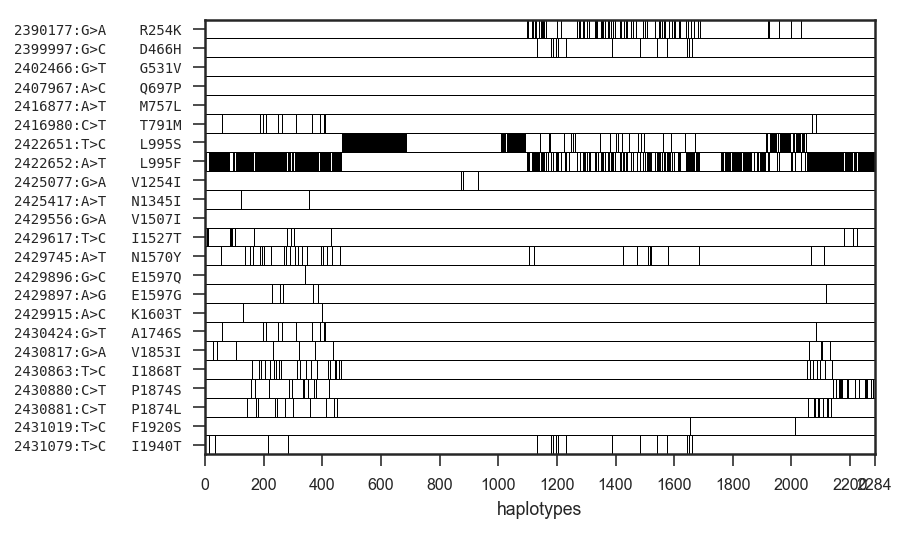

In [15]:
plot_haplotypes_split(haps_vgsc_missense, lbl_vgsc_missense)

In [16]:
rcParams['lines.linewidth'] = .5

In [23]:
def plot_cladogram(dist, yscale='symlog', yscale_kws=None, ylim=(10, 1e6), count_sort=True, cut_height=2e3,
                   linkage_method='average', n_clusters=16, fill_threshold=0, leaf_height=0, linewidth=2,
                   figsize=(9, 6), dpi=300, cluster_names=[]):
    
    # perform hierarchical clustering
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)
    # needed for getting leaves in right order
    r = scipy.cluster.hierarchy.dendrogram(
        z, count_sort=count_sort, no_plot=True)

    # setup figure
    fig = plt.figure(figsize=figsize, dpi=120)
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, 5, 0.4], hspace=0)
    
    # setup  vspans - find clusters
    f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
    # compute cluster sizes
    fsz = np.bincount(f)
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    # take largest n
    fsort = fsort[:n_clusters]
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster]) 
                       for cluster in clusters]
    ixs = np.argsort([len(cl) for cl in clusters_leaves])[::-1]
    clusters = [clusters[i] for i in ixs]
    clusters_leaves = [clusters_leaves[i] for i in ixs]
    
    #------------------------------------------------------------------------------------------

    # plot cladogram
    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    colors = [pop_colors[p] for p in df_haplotypes.population]
    hapclust.cladogram(z, count_sort=True, colors=colors, 
                       fill_threshold=fill_threshold, leaf_height=leaf_height, 
                       plot_kws=dict(linewidth=linewidth), 
                       fill_kws=dict(linewidth=linewidth), 
                       ax=ax)
    ax.set_ylim(*ylim)
    if yscale_kws is None:
        yscale_kws = dict()
    ax.set_yscale(yscale, **yscale_kws)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(r['leaves']), 200)) + [len(r['leaves'])])
    xticks = xticklabels / len(r['leaves'])
    xticks = (xticks * (xmax - xmin)) + xmin
    #ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Haplotype age (generations)')
    ax.grid(axis='y', linestyle='--', zorder=-1e9, linewidth=.5)
    ax.axhline(cut_height, linestyle='--', linewidth=1, color='r')
    
    #legend
#     allpop = list(pop_colors.keys())
#     ninepop = allpop.remove('colony')
    #ninecol = [phase1_ar3.pop_colors[p] for p in ninepop]
    handles = [mpl.patches.Patch(color=pop_colors[pop], label=pop_labels[pop]) for pop in populations]
    ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, prop={'size': 10}, frameon=True, framealpha=1)
    
    #------------------------------------------------------------------------------------------
        
    # plot display haplotypes
    ax = fig.add_subplot(gs[1])
    plot_haplotypes_split(haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense, ax=ax)
    ax.set_xlim(0, len(r['leaves']))
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('Non-synonymous SNPs')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if i in cluster_names:
                x1, x2 = min(cluster_leaves), max(cluster_leaves)
                ax.axvline(x1, color='k', linestyle='--', zorder=20)
                ax.axvline(x2, color='k', linestyle='--', zorder=20)
                ax.axvspan(x1, x2, color='k', zorder=20, alpha=.1)
    
    #------------------------------------------------------------------------------------------

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[2])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, len(r['leaves']))
    ax_clu.set_ylim(0, 1)
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if i in cluster_names:
                xmin, xmax = min(cluster_leaves), max(cluster_leaves)
                fraction = -20 / (xmax - xmin)
                ax_clu.annotate("", ha='left', va='center',
                                xy=(xmin, 1), xycoords='data',
                                xytext=(xmax, 1), textcoords='data',
                                arrowprops=dict(arrowstyle="-",
                                                connectionstyle="bar,fraction=%.4f" % fraction,
                                                ),
                                )
                ax_clu.text((xmax + xmin)/2, 0, cluster_names[i], va='top', ha='center', fontsize=12)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
                  
    #------------------------------------------------------------------------------------------

    gs.tight_layout(fig, h_pad=-0.2)
#     fn = '../artwork/fig_hap_tree.png'
#     fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')

In [24]:
cluster_names = {
    0: 'F1',
    1: 'F5',
    2: 'S3',
    3: 'S1',
    4: 'S2',
    5: 'S4/5',
    6: 'F3',
    8: 'L1',
    10: 'F4',
    18: 'F2',
}

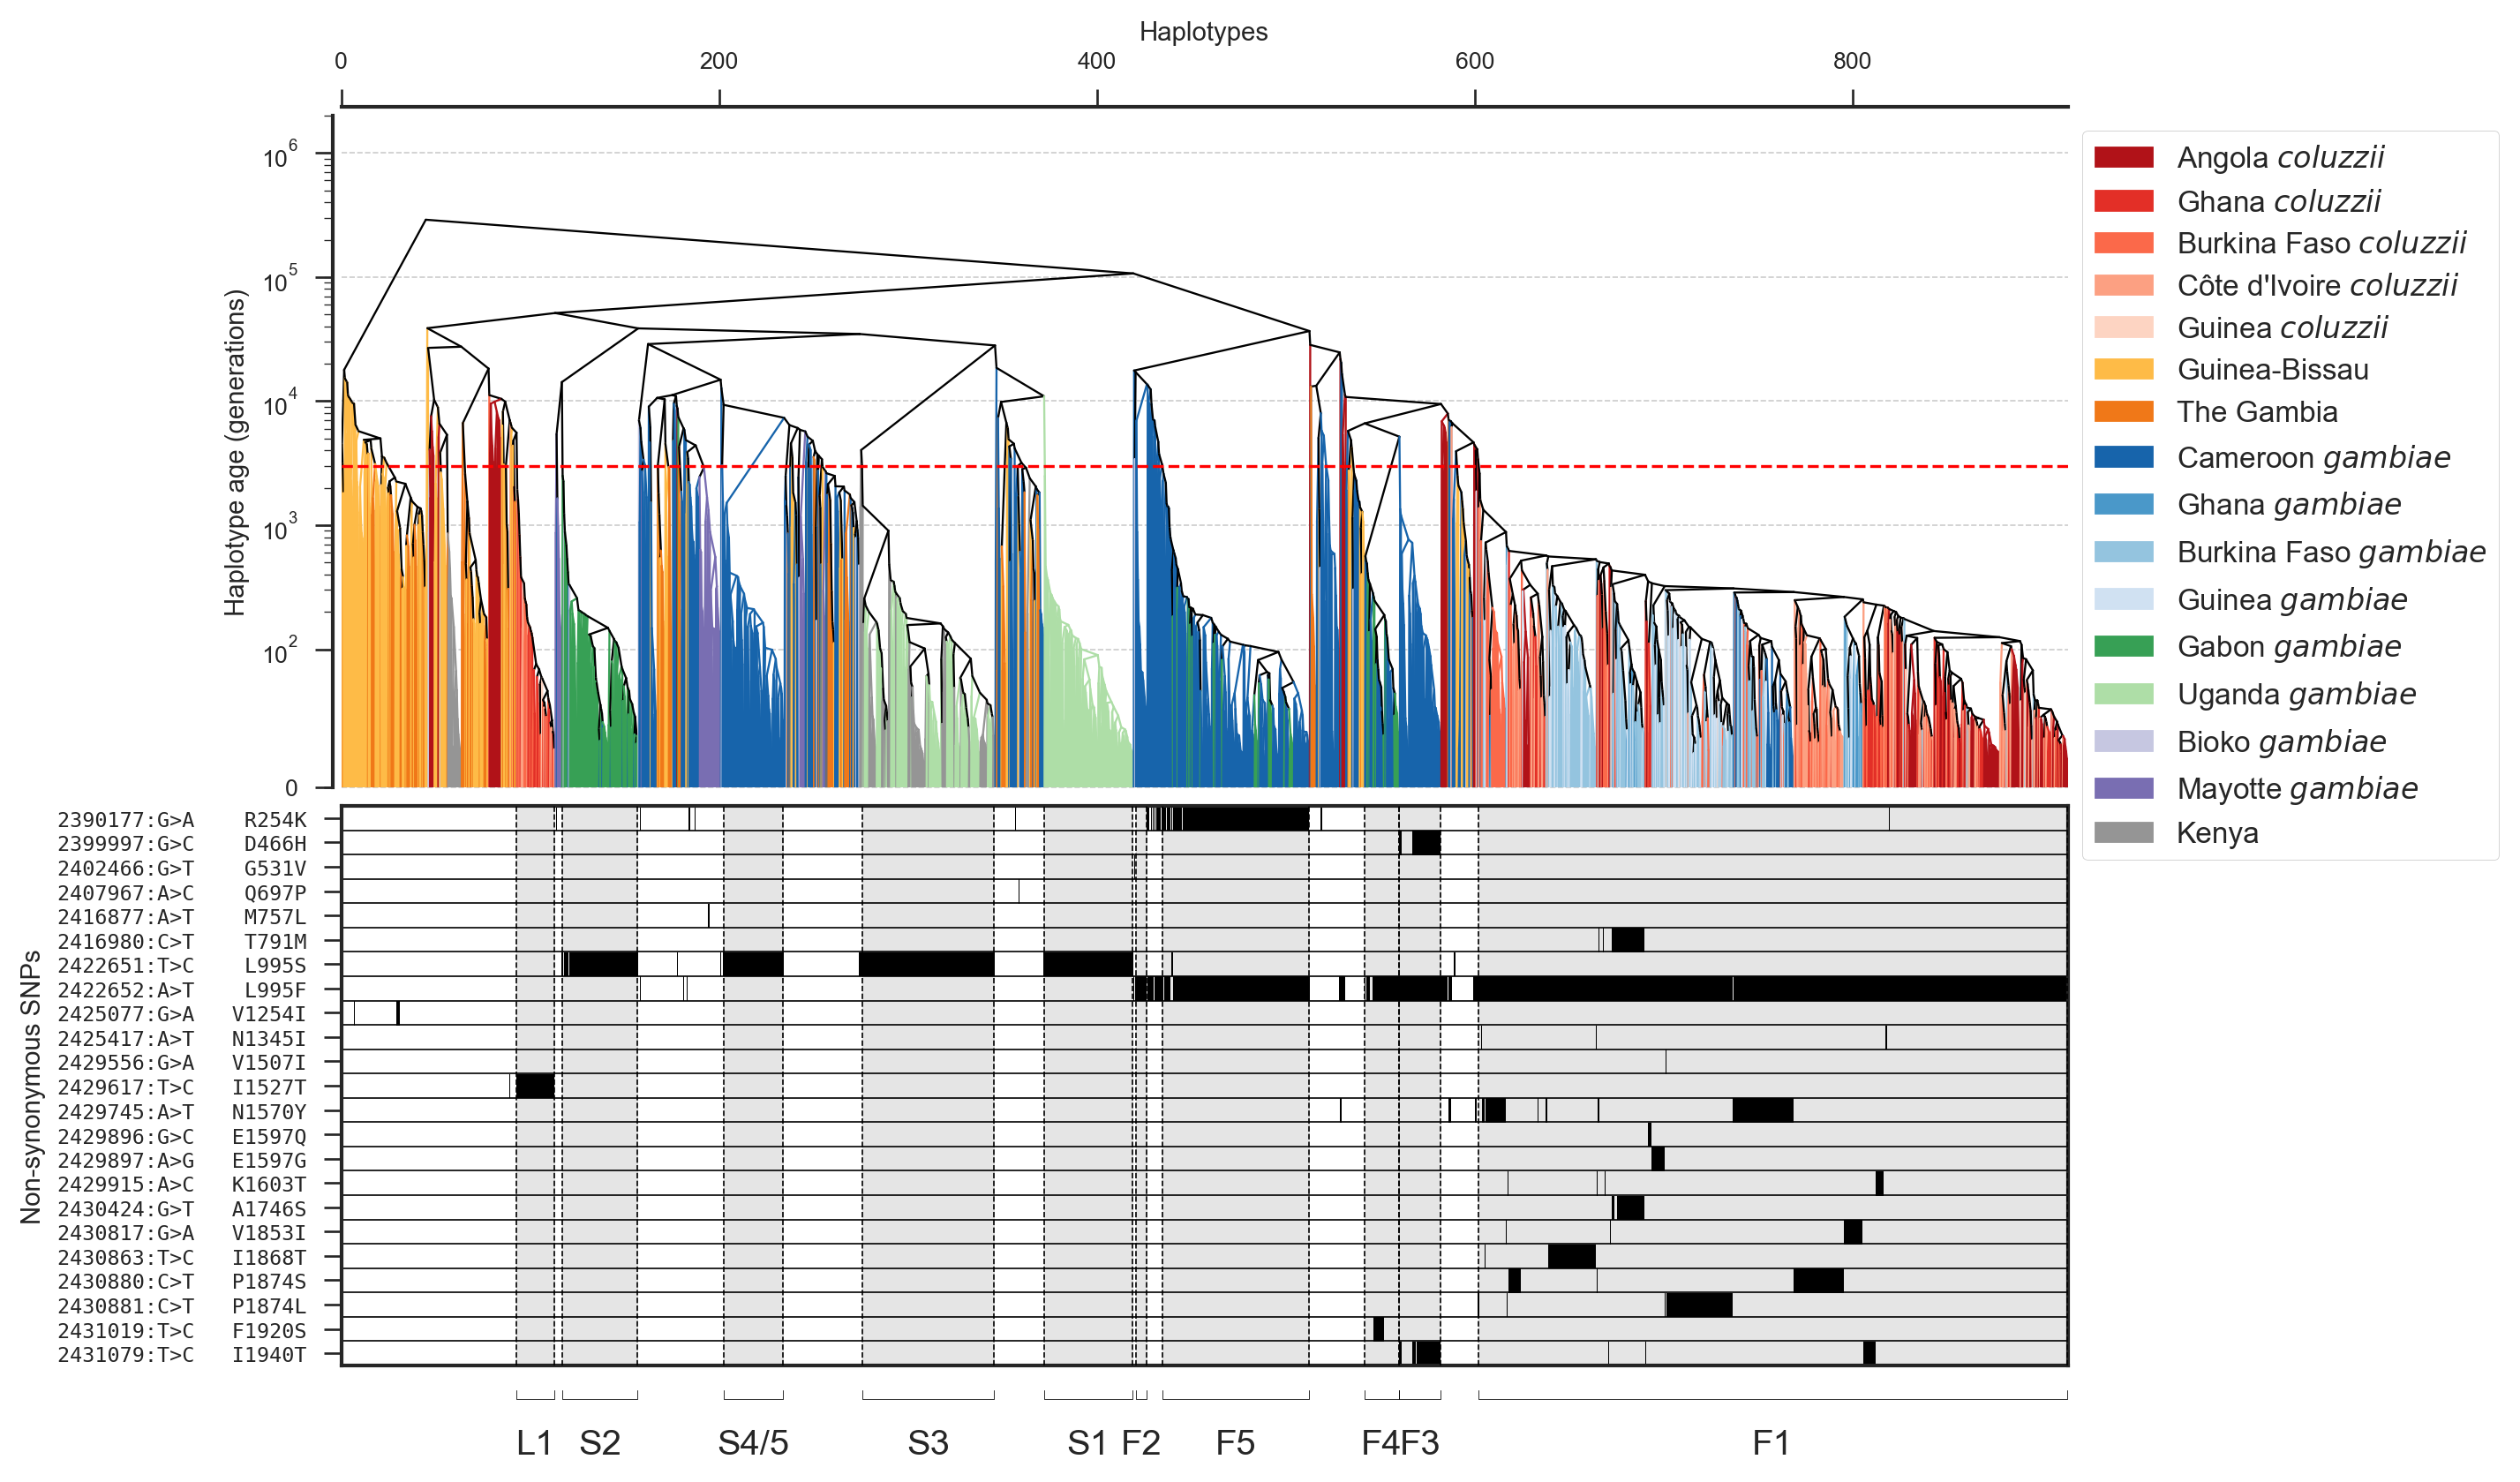

In [25]:
plot_cladogram(pw_t_hat, fill_threshold=0, linewidth=0.7, leaf_height=0,
               figsize=(10, 7), dpi=600, ylim=(0, 2e6), yscale='symlog', 
               yscale_kws=dict(linthreshy=100, linscaley=1.0, subsy=list(range(1, 10))),
               cluster_names=cluster_names, n_clusters=20, cut_height=3e3)